# housekeeping

In [16]:
import os

import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

import time
from xbart import XBART
from xbcausalforest import XBCF
import seaborn as sns

In [2]:
RANDOM_SEED = 1013

# データ探索

In [3]:
path = os.getcwd()  # works only in case it's launched from examples folder
fileloc = path + '/GoalsAndGaps/Goals_new/dataset/dataset_CarlanaLaFerrara_Pinotti_ECMA2020.dta'
print(fileloc)

/Users/domolm/Library/CloudStorage/GoogleDrive-domokomod5@gmail.com/My Drive/Learning/研究計画/GoalsAndGaps/Goals_new/dataset/dataset_CarlanaLaFerrara_Pinotti_ECMA2020.dta


In [4]:
df = pd.read_stata(fileloc)
df.columns

Index(['program', 'treat', 'treat_school', 'treat_c', 'late', 'female', 'rank',
       'potential_program', 'prov1', 'prov2', 'prov3', 'prov4', 'prov5',
       'perc_participation', 'participation_calpII', 'participation_calpIII',
       'participation_orientII', 'participation_orientIII',
       'quest_control_school', 'itano', 'matno', 'invalsiIII', 'itaIII',
       'matIII', 'educmother_high', 'bluemother', 'whitemother', 'unempmother',
       'homemother', 'bluefather', 'whitefather', 'unempfather', 'homefather',
       'educmotherI', 'educmotherII', 'educmotherIII', 'educfatherI',
       'educfatherII', 'educfatherIII', 'educmother_high_2', 'barriers',
       'motivation', 'f1_obiettivi_studio', 'f2_universita',
       'f4_disponibilita_economiche', 'f4_idee_della_famiglia',
       'f4_pregiudizi_non_italiano', 'f4_progetti_familiari',
       'f4_non_sentirsi_all_altezza', 'l2_lavoro_intellettuale',
       'l2_dirigente', 'immigrato_prima_gen', 'comparable_italians', 'prov',
     

In [5]:
np.array(sorted(df.columns))

array(['Albania', 'Cina', 'Ecuador', 'Filippine', 'Marocco', 'Peru',
       'Romania', 'barriers', 'bluefather', 'bluemother', 'bonus75',
       'change_school', 'choice_track', 'choice_track3', 'class_size',
       'comparable_italians', 'dropout', 'educfatherI', 'educfatherII',
       'educfatherIII', 'educmotherI', 'educmotherII', 'educmotherIII',
       'educmother_high', 'educmother_high_2', 'educmother_high_2_treat',
       'educmother_low_2', 'educmother_low_2_treat', 'educmother_missing',
       'educmother_missing_treat', 'eu_member', 'eu_member_treat',
       'f1_obiettivi_studio', 'f2_universita',
       'f4_disponibilita_economiche', 'f4_idee_della_famiglia',
       'f4_non_sentirsi_all_altezza', 'f4_pregiudizi_non_italiano',
       'f4_progetti_familiari', 'fail', 'female', 'homefather',
       'homemother', 'immigrato_prima_gen', 'invalsiIII', 'invalsi_mean',
       'itaIII', 'itano', 'l2_dirigente', 'l2_lavoro_intellettuale',
       'late', 'lictec2', 'matIII', 'matno', 

In [6]:
df.program_c.value_counts()

0.0    51802
1.0    16548
Name: program_c, dtype: int64

In [7]:
df.treat_c.value_counts()

0.0    60498
1.0     7852
Name: treat_c, dtype: int64

恐らくだが、program_c はポテンシャルのある学生（top 10学生）がいるクラス。treat_c はポテンシャルがあり、かつ実際に EOP に割り当てられた学生がいるクラス。

In [8]:
df.potential_program.value_counts()

0.0    18700
1.0     3793
Name: potential_program, dtype: int64

potential_program は、1 であれば移民である変数っぽい。

In [9]:
df.treat.value_counts()

0.0    67680
1.0      670
Name: treat, dtype: int64

In [10]:
df.program.value_counts()

0.0    66969
1.0     1381
Name: program, dtype: int64

program は top10 に入る成績の学生、treat は top10 に入り、尚且つ EOP に割り当てられた学生？

In [11]:
df.school_code.value_counts().sort_index()

1.0      221
2.0      329
3.0      187
4.0      221
5.0      149
        ... 
139.0    125
140.0     10
141.0     57
142.0      3
143.0     30
Name: school_code, Length: 143, dtype: int64

全部で 143 校。

global control "female immigrato_prima_gen stdinvalsiI stdinvalsiI_2"  
global school "class_size perc_imm school_size" 

# データ加工

In [12]:
df = pd.read_stata(fileloc)
df = df[df['program_c']==1]
df = df.drop(df[df['program']==1].index)

「EOP に選ばられるポテンシャルを持つ生徒」の「クラスメイト」を抽出（実際に EOP に選ばれた生徒のクラスメイトと、選ばれなかった生徒のクラスメイト）

In [13]:
df.shape

(15167, 96)

移民に絞る

In [14]:
df = df[df['potential_program']==1]
df.shape

(1743, 96)

In [15]:
controls = ['female', 'immigrato_prima_gen', 'stdinvalsiI', 'stdinvalsiI_2', 'prov2', 'prov3', 'prov4', 'prov5']
school = ["class_size", "perc_imm", "school_size"]
variables = ['treat_c'] + controls + school
df[variables].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1743 entries, 13 to 69908
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   treat_c              1743 non-null   float32
 1   female               1743 non-null   float32
 2   immigrato_prima_gen  1743 non-null   float32
 3   stdinvalsiI          1743 non-null   float32
 4   stdinvalsiI_2        1743 non-null   float32
 5   prov2                1743 non-null   float64
 6   prov3                1743 non-null   float64
 7   prov4                1743 non-null   float64
 8   prov5                1743 non-null   float64
 9   class_size           1743 non-null   float32
 10  perc_imm             1743 non-null   float32
 11  school_size          1743 non-null   float32
dtypes: float32(8), float64(4)
memory usage: 122.6 KB


In [16]:
outputs = ['lictec2', 'fail', 'stdinvalsiIII', 'recc_lictec2']
df[outputs].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1743 entries, 13 to 69908
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lictec2        1308 non-null   float32
 1   fail           1308 non-null   float32
 2   stdinvalsiIII  1007 non-null   float32
 3   recc_lictec2   1308 non-null   float32
dtypes: float32(4)
memory usage: 40.9 KB


In [17]:
df = df.reset_index()

In [18]:
df_nona = df[variables+outputs+['school_code']].dropna().reset_index(drop=True).copy()
df_nona[df_nona['treat_c']==1]

,treat_c,female,immigrato_prima_gen,stdinvalsiI,stdinvalsiI_2,prov2,prov3,prov4,prov5,class_size,perc_imm,school_size,lictec2,fail,stdinvalsiIII,recc_lictec2,school_code
2,1.0,0.0,1.0,-0.093905,0.008818,0.0,0.0,0.0,0.0,27.0,0.296296,125.0,0.0,0.0,-0.554233,0.0,25.0
3,1.0,0.0,0.0,-1.139284,1.297968,0.0,0.0,0.0,0.0,26.0,0.230769,150.0,0.0,0.0,-0.365333,0.0,85.0
7,1.0,1.0,1.0,-0.756790,0.572731,0.0,0.0,0.0,1.0,24.0,0.333333,222.0,0.0,0.0,-0.623793,0.0,7.0
12,1.0,0.0,1.0,-1.757207,3.087776,0.0,1.0,0.0,0.0,25.0,0.360000,94.0,0.0,0.0,-1.507507,0.0,108.0
14,1.0,0.0,0.0,-1.126482,1.268963,0.0,1.0,0.0,0.0,22.0,0.227273,328.0,0.0,0.0,-1.656452,0.0,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.0,0.0,1.0,-0.661245,0.437245,0.0,0.0,0.0,1.0,26.0,0.461538,74.0,1.0,0.0,-0.375420,1.0,58.0
996,1.0,0.0,1.0,-0.648443,0.420479,0.0,0.0,0.0,1.0,24.0,0.291667,293.0,1.0,0.0,-1.080715,1.0,11.0
1000,1.0,1.0,1.0,-1.725358,2.976862,0.0,0.0,0.0,1.0,25.0,0.360000,221.0,1.0,0.0,-0.842167,1.0,3.0
1001,1.0,0.0,1.0,-0.622840,0.387929,0.0,0.0,1.0,0.0,25.0,0.240000,216.0,0.0,0.0,-1.855045,0.0,50.0


# 分析

In [19]:
original_array = df_nona['school_code'].astype(int).values

# 使われている番号の一覧を取得
used_numbers = np.unique(original_array)

# 番号を振り直すための辞書を作成
number_mapping = {number: i for i, number in enumerate(used_numbers)}

# 新たな配列を作成して番号を振り直す
new_array = np.array([number_mapping[number] for number in original_array])

print(original_array)
print(new_array)

[83 91 25 ... 50 86 88]
[71 79 18 ... 41 74 76]


In [20]:
COORDS = {
    'school_code': np.unique(df_nona['school_code']),
    'variables': df_nona[variables].columns.values
    }
with pm.Model(coords=COORDS) as fixed:
    school_idx = pm.MutableData("school_idx", new_array)

    # prior
    alpha = pm.Normal('alpha', mu=0, sigma=1, dims='school_code')
    beta = pm.Normal('beta', mu=0.0, sigma=10.0, dims='variables')

    sd_y = pm.Exponential('sd_y', 10)

    y_hat = alpha[school_idx] + pm.math.dot(df_nona[variables].values, beta)

    y_like = pm.Normal('y_like', mu=y_hat, sigma=sd_y, observed=df_nona['stdinvalsiIII'])

    

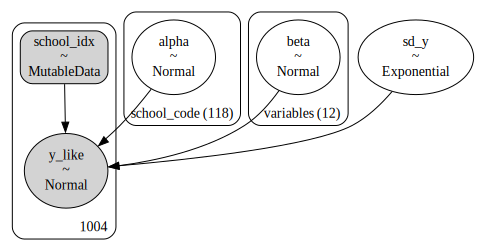

In [21]:
pm.model_to_graphviz(fixed)

In [22]:
with fixed:
    trace = pm.sample(tune=2000, chains=4, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [alpha, beta, sd_y]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 112 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [23]:
az.summary(trace.posterior['beta'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[treat_c],-0.043,0.186,-0.421,0.280,0.010,0.007,362.0,763.0,1.02
beta[female],-0.010,0.043,-0.091,0.071,0.001,0.001,3057.0,2924.0,1.00
beta[immigrato_prima_gen],0.047,0.044,-0.040,0.126,0.001,0.001,2605.0,2782.0,1.00
beta[stdinvalsiI],0.844,0.073,0.705,0.976,0.002,0.001,1657.0,2268.0,1.00
beta[stdinvalsiI_2],0.114,0.032,0.059,0.176,0.001,0.001,1685.0,2145.0,1.00
beta[prov2],0.071,0.428,-0.724,0.857,0.020,0.014,452.0,942.0,1.01
beta[prov3],0.007,0.233,-0.420,0.444,0.015,0.011,247.0,461.0,1.02
beta[prov4],-0.055,0.516,-0.992,0.943,0.021,0.015,613.0,955.0,1.01
beta[prov5],0.031,0.316,-0.563,0.646,0.019,0.014,270.0,679.0,1.01
beta[class_size],-0.001,0.008,-0.016,0.013,0.000,0.000,652.0,1184.0,1.01


array([[<Axes: title={'center': 'beta\ntreat_c'}>,
        <Axes: title={'center': 'beta\nfemale'}>,
        <Axes: title={'center': 'beta\nimmigrato_prima_gen'}>],
       [<Axes: title={'center': 'beta\nstdinvalsiI'}>,
        <Axes: title={'center': 'beta\nstdinvalsiI_2'}>,
        <Axes: title={'center': 'beta\nprov2'}>],
       [<Axes: title={'center': 'beta\nprov3'}>,
        <Axes: title={'center': 'beta\nprov4'}>,
        <Axes: title={'center': 'beta\nprov5'}>],
       [<Axes: title={'center': 'beta\nclass_size'}>,
        <Axes: title={'center': 'beta\nperc_imm'}>,
        <Axes: title={'center': 'beta\nschool_size'}>]], dtype=object)

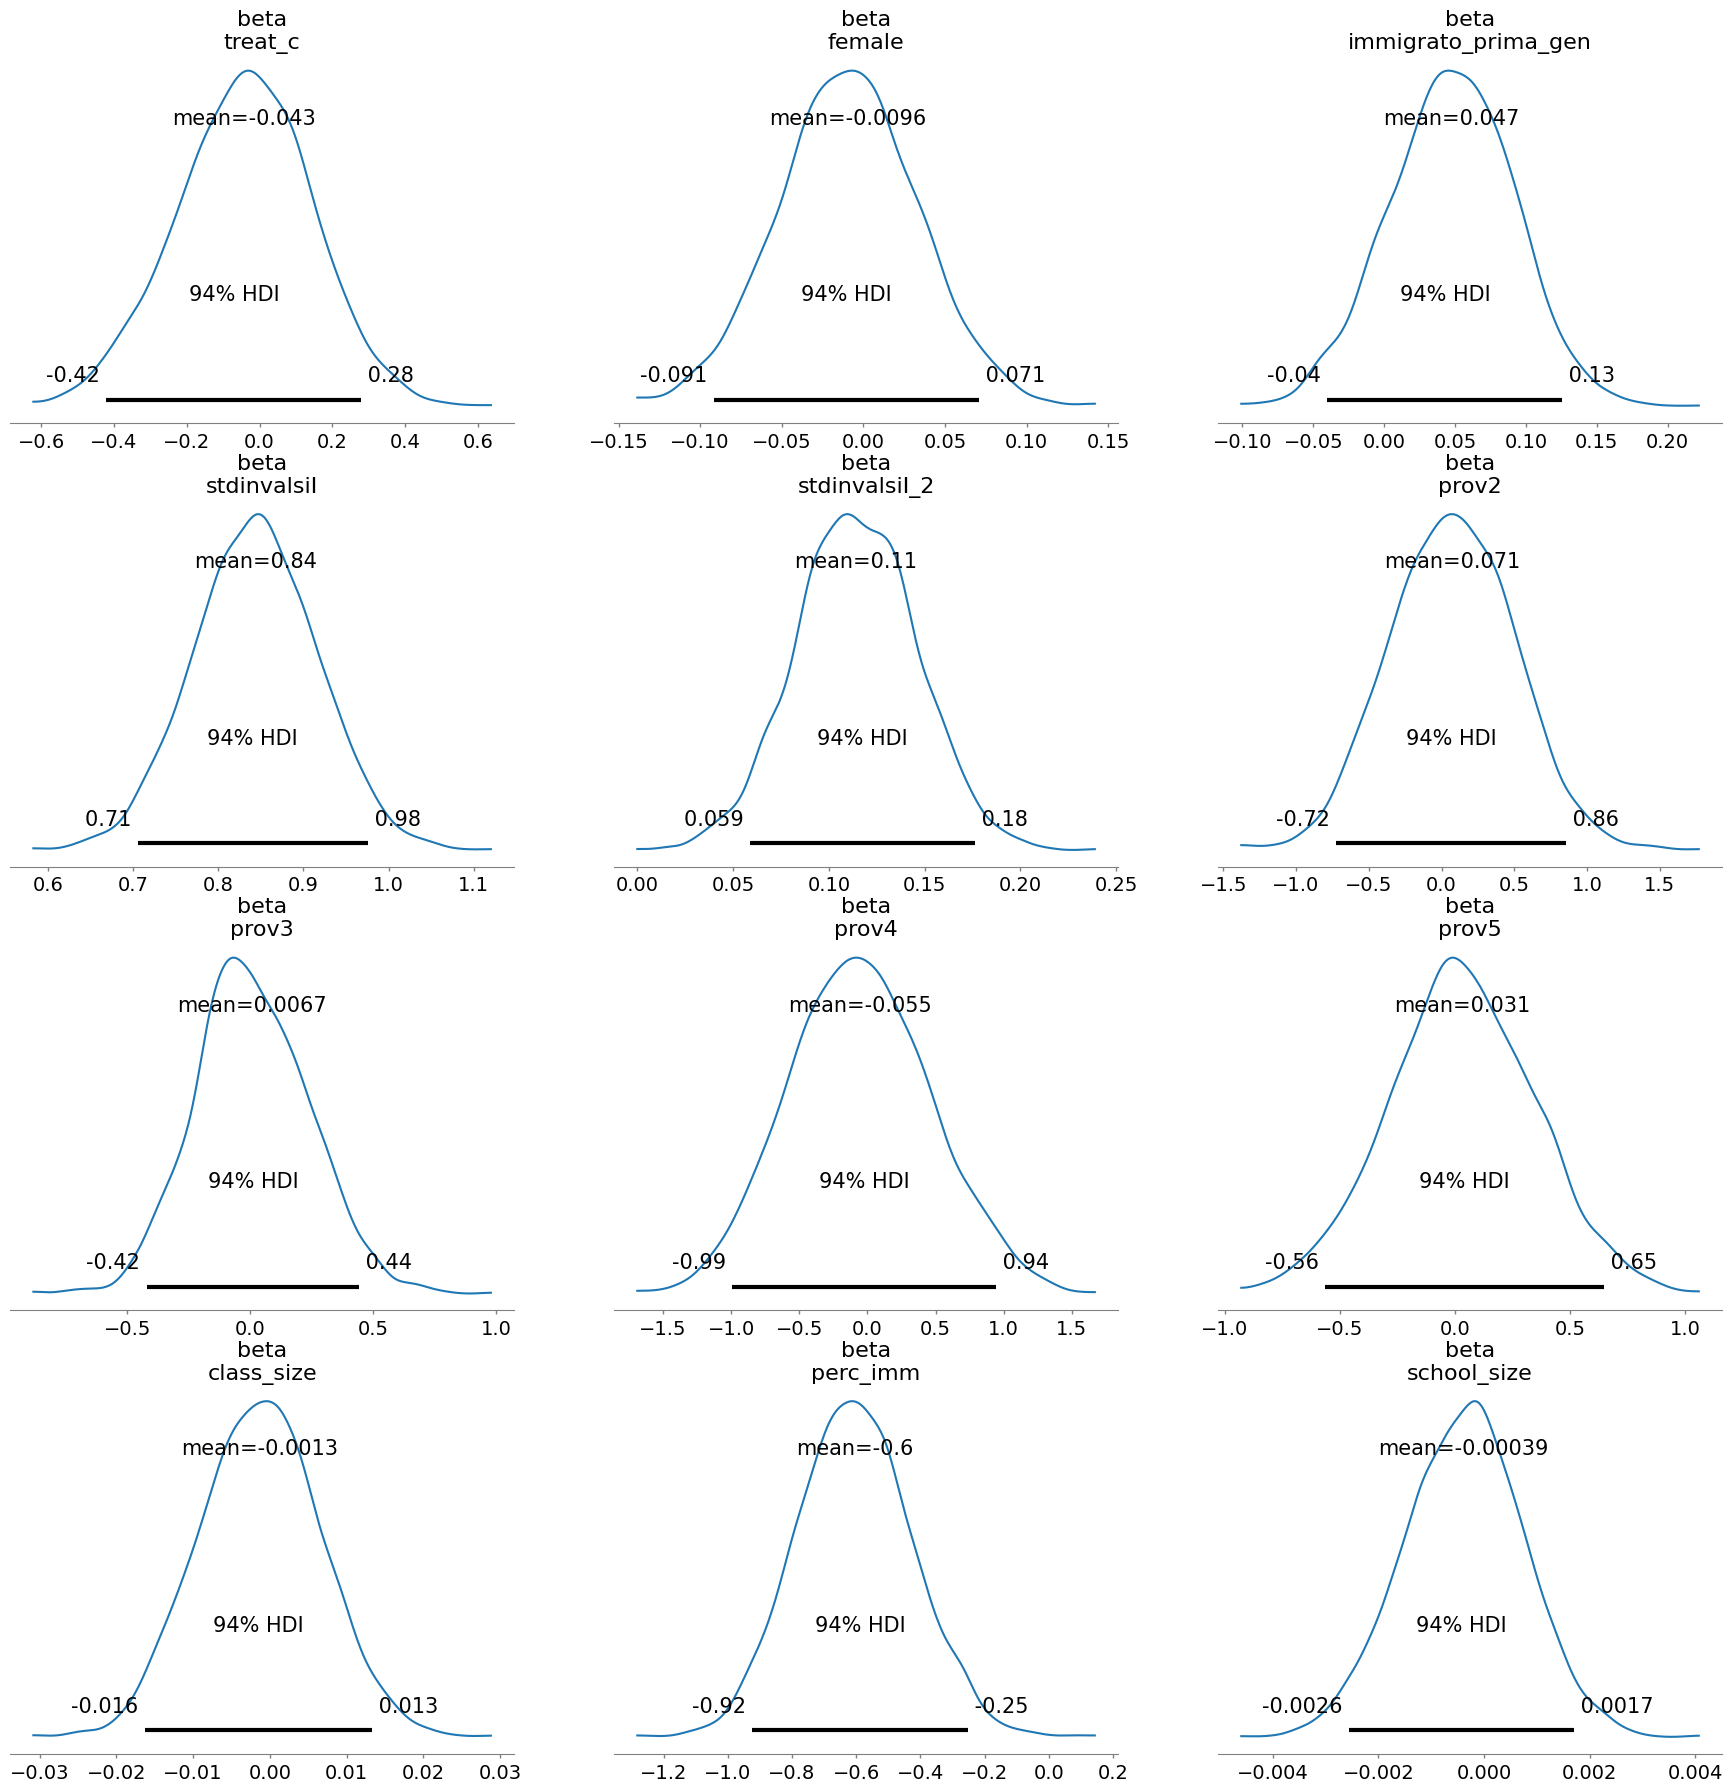

In [24]:
az.plot_posterior(trace.posterior['beta'])

# 分析2

In [25]:
COORDS = {
    'school_code': np.unique(df_nona['school_code']),
    'variables': df_nona[variables].columns.values
    }
with pm.Model(coords=COORDS) as random:
    school_idx = pm.MutableData("school_idx", new_array)

    # Priors
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=10.)
    sigma_a = pm.Exponential("sigma_a", 10.)

    # prior
    alpha = pm.Normal('alpha', mu=mu_a, sigma=sigma_a, dims='school_code')
    beta = pm.Normal('beta', mu=0., sigma=10., dims='variables')

    sd_y = pm.Exponential('sd_y', 10.)

    y_hat = alpha[school_idx] + pm.math.dot(df_nona[variables].values, beta)

    y_like = pm.Normal('y_like', mu=y_hat, sigma=sd_y, observed=df_nona['stdinvalsiIII'])


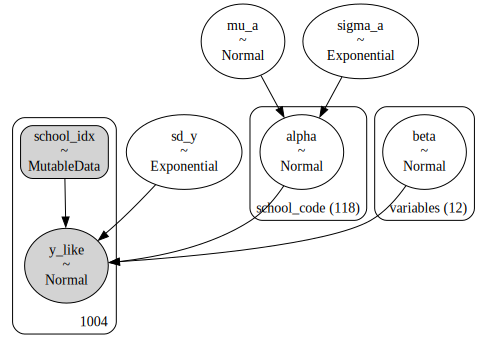

In [26]:
pm.model_to_graphviz(random)

In [27]:
with random:
    trace_random = pm.sample(draws=4000, chains=4, tune=2000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [mu_a, sigma_a, alpha, beta, sd_y]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 174 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.


In [28]:
az.summary(trace_random)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_a,-0.231,0.258,-0.699,0.270,0.022,0.016,136.0,266.0,1.05
alpha[1.0],-0.342,0.290,-0.872,0.217,0.022,0.015,181.0,456.0,1.04
alpha[2.0],-0.245,0.291,-0.782,0.306,0.023,0.016,163.0,350.0,1.04
alpha[3.0],-0.251,0.303,-0.782,0.357,0.023,0.016,178.0,482.0,1.04
alpha[4.0],-0.093,0.302,-0.672,0.461,0.023,0.016,176.0,454.0,1.04
...,...,...,...,...,...,...,...,...,...
beta[class_size],0.006,0.009,-0.012,0.021,0.001,0.000,175.0,459.0,1.04
beta[perc_imm],-0.278,0.158,-0.575,0.016,0.007,0.005,528.0,1816.0,1.01
beta[school_size],-0.000,0.000,-0.001,0.000,0.000,0.000,1728.0,6965.0,1.00
sigma_a,0.180,0.027,0.128,0.231,0.001,0.000,1905.0,2025.0,1.00


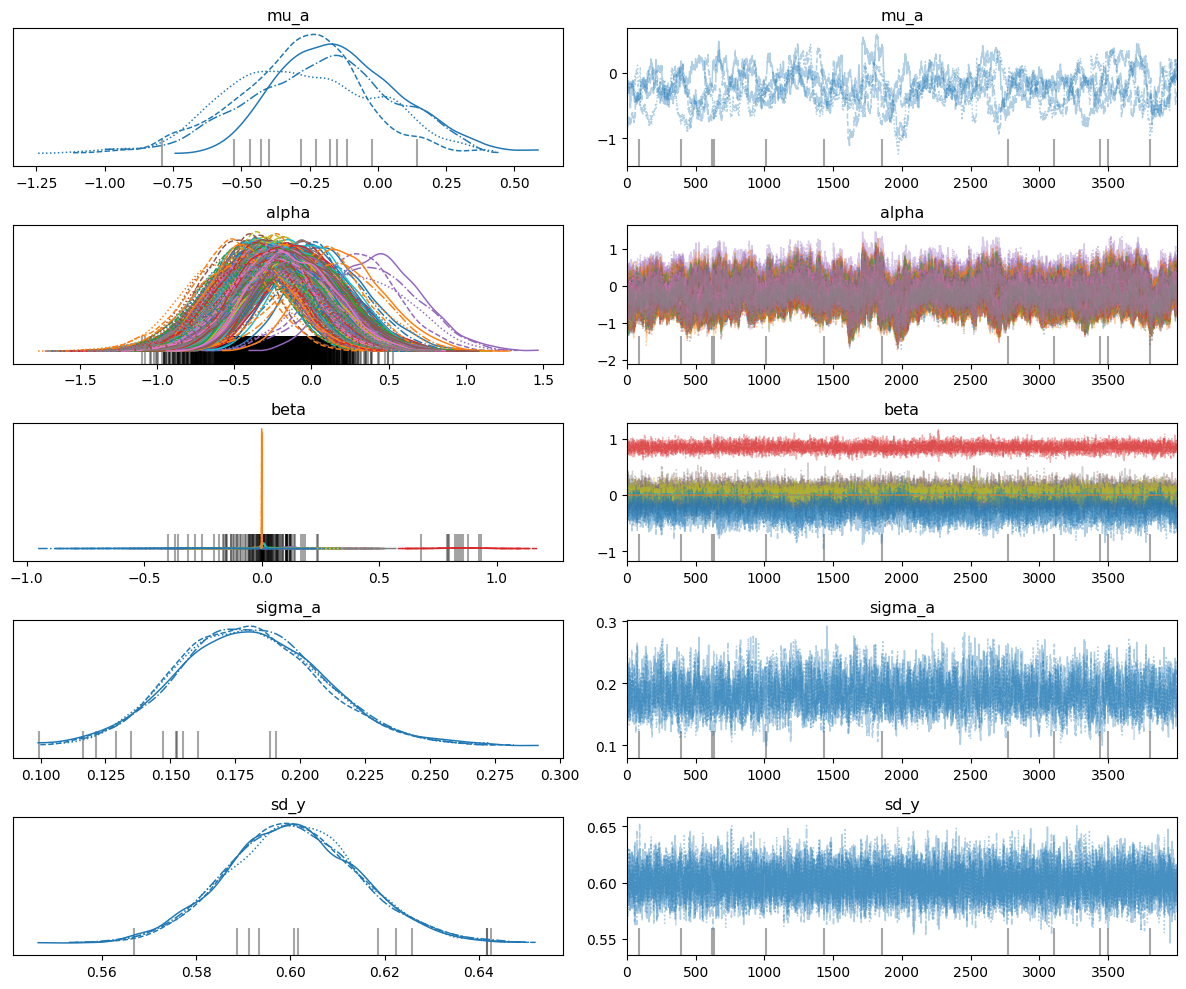

In [29]:
az.plot_trace(trace_random)
plt.tight_layout()

array([[<Axes: title={'center': 'beta\ntreat_c'}>,
        <Axes: title={'center': 'beta\nfemale'}>,
        <Axes: title={'center': 'beta\nimmigrato_prima_gen'}>],
       [<Axes: title={'center': 'beta\nstdinvalsiI'}>,
        <Axes: title={'center': 'beta\nstdinvalsiI_2'}>,
        <Axes: title={'center': 'beta\nprov2'}>],
       [<Axes: title={'center': 'beta\nprov3'}>,
        <Axes: title={'center': 'beta\nprov4'}>,
        <Axes: title={'center': 'beta\nprov5'}>],
       [<Axes: title={'center': 'beta\nclass_size'}>,
        <Axes: title={'center': 'beta\nperc_imm'}>,
        <Axes: title={'center': 'beta\nschool_size'}>]], dtype=object)

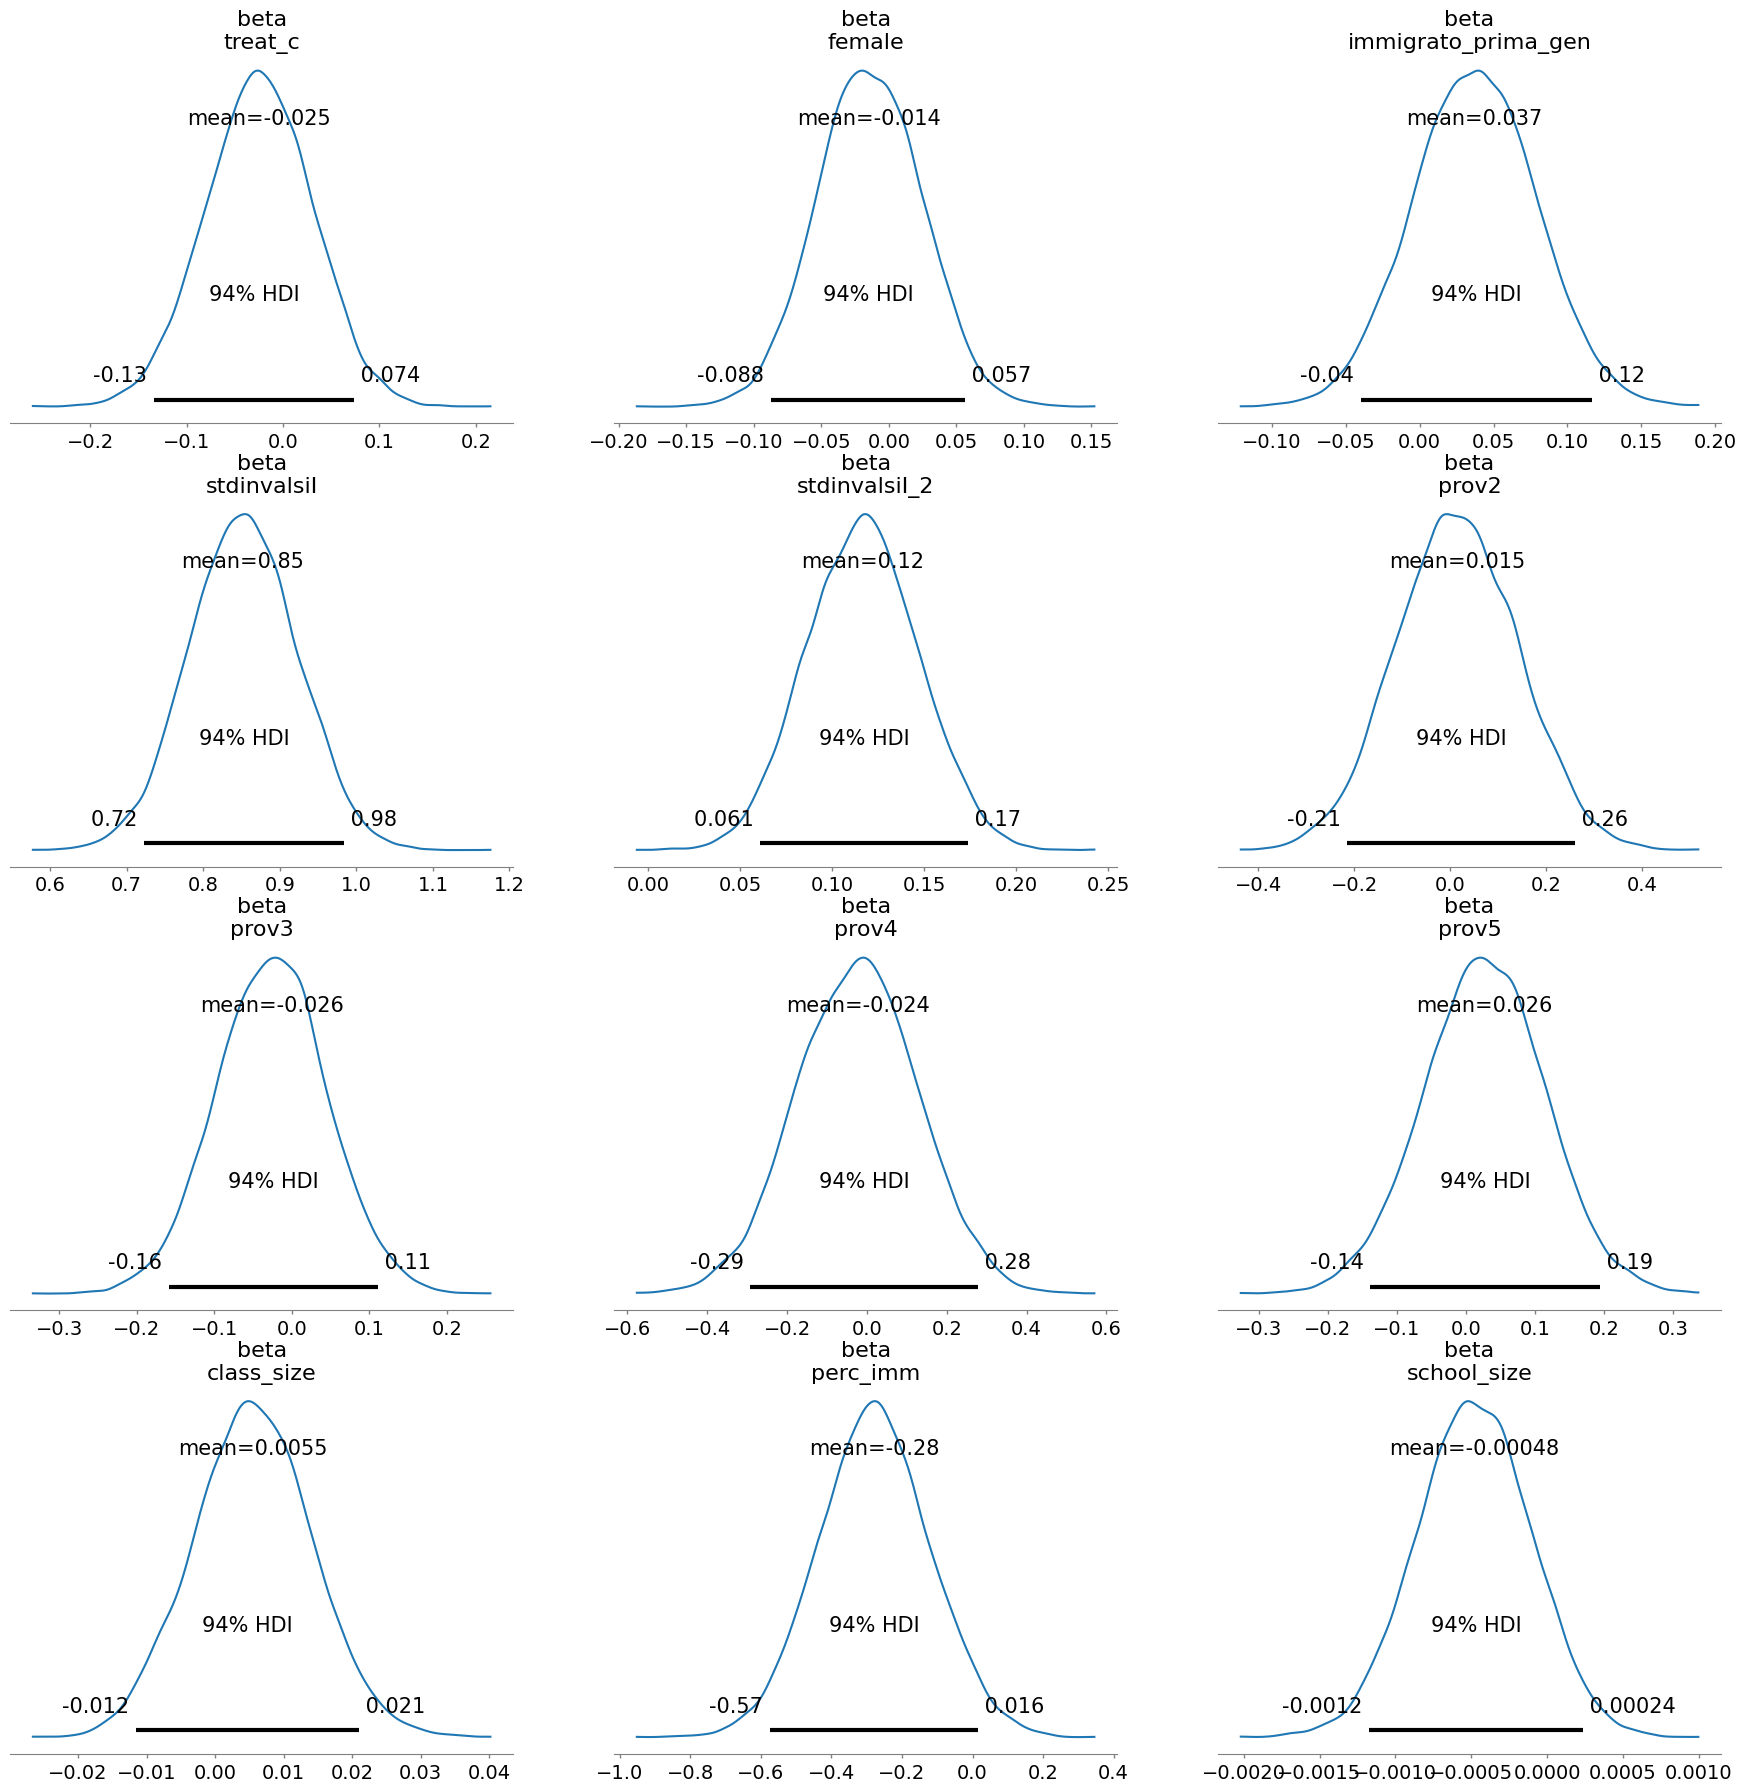

In [30]:
az.plot_posterior(trace_random.posterior['beta'])

# 分析3

上の分析と同じ変数で BCF

In [31]:
import time
from xbart import XBART
from xbcausalforest import XBCF
import seaborn as sns

In [32]:
df_nona = df[variables+outputs+['school_code']].dropna().reset_index(drop=True).copy()
df_nona

,treat_c,female,immigrato_prima_gen,stdinvalsiI,stdinvalsiI_2,prov2,prov3,prov4,prov5,class_size,perc_imm,school_size,lictec2,fail,stdinvalsiIII,recc_lictec2,school_code
0,0.0,0.0,1.0,-1.502311,2.256938,0.0,0.0,0.0,0.0,25.0,0.240000,125.0,0.0,0.0,-2.083637,0.0,83.0
1,0.0,0.0,1.0,-1.591522,2.532943,0.0,1.0,0.0,0.0,27.0,0.370370,159.0,0.0,0.0,-1.209617,0.0,91.0
2,1.0,0.0,1.0,-0.093905,0.008818,0.0,0.0,0.0,0.0,27.0,0.296296,125.0,0.0,0.0,-0.554233,0.0,25.0
3,1.0,0.0,0.0,-1.139284,1.297968,0.0,0.0,0.0,0.0,26.0,0.230769,150.0,0.0,0.0,-0.365333,0.0,85.0
4,0.0,1.0,1.0,-1.495939,2.237832,0.0,0.0,0.0,0.0,24.0,0.458333,139.0,0.0,0.0,-1.964429,0.0,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,0.0,0.0,1.0,-0.642058,0.412239,0.0,1.0,0.0,0.0,23.0,0.173913,307.0,1.0,0.0,-0.514409,1.0,47.0
1000,1.0,1.0,1.0,-1.725358,2.976862,0.0,0.0,0.0,1.0,25.0,0.360000,221.0,1.0,0.0,-0.842167,1.0,3.0
1001,1.0,0.0,1.0,-0.622840,0.387929,0.0,0.0,1.0,0.0,25.0,0.240000,216.0,0.0,0.0,-1.855045,0.0,50.0
1002,0.0,1.0,0.0,-0.744014,0.553557,0.0,0.0,0.0,0.0,26.0,0.384615,165.0,0.0,0.0,-1.100364,0.0,86.0


In [33]:
quant_cols_idx = np.array([3,4,9,10,11,16])
qual_cols_idx = np.array([1,2,5,6,7,8])
outputs_idx = np.array([12,13,14,15])
treat_idx = np.array([0])

In [34]:
# xbcf 用に共変量の並びを変える
df_covar = \
df_nona.reindex(
    columns=np.concatenate([
                df_nona.iloc[:,quant_cols_idx].columns.values,
                df_nona.iloc[:,qual_cols_idx].columns.values,
            ])
)
df_covar

,stdinvalsiI,stdinvalsiI_2,class_size,perc_imm,school_size,school_code,female,immigrato_prima_gen,prov2,prov3,prov4,prov5
0,-1.502311,2.256938,25.0,0.240000,125.0,83.0,0.0,1.0,0.0,0.0,0.0,0.0
1,-1.591522,2.532943,27.0,0.370370,159.0,91.0,0.0,1.0,0.0,1.0,0.0,0.0
2,-0.093905,0.008818,27.0,0.296296,125.0,25.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-1.139284,1.297968,26.0,0.230769,150.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.495939,2.237832,24.0,0.458333,139.0,80.0,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
999,-0.642058,0.412239,23.0,0.173913,307.0,47.0,0.0,1.0,0.0,1.0,0.0,0.0
1000,-1.725358,2.976862,25.0,0.360000,221.0,3.0,1.0,1.0,0.0,0.0,0.0,1.0
1001,-0.622840,0.387929,25.0,0.240000,216.0,50.0,0.0,1.0,0.0,0.0,1.0,0.0
1002,-0.744014,0.553557,26.0,0.384615,165.0,86.0,1.0,0.0,0.0,0.0,0.0,0.0


## 変数定義

In [35]:
y = df_nona['stdinvalsiIII'].to_numpy()
z = df_nona['treat_c'].to_numpy()
X = df_covar.to_numpy()
z = z.astype(np.int32)

In [36]:
d_t = X.shape[1]
n = X.shape[0]

## propensity score estimation

In [37]:
start = time.time()
xbt = XBART(num_trees=100, num_sweeps=40, burnin=15)
xb_fit = xbt.fit_predict(X, z, X)
xb_fit = xb_fit.reshape((n, 1))

end = time.time()
print("second elapsed XBART for pihat: ", end - start)

second elapsed XBART for pihat:  1.986586093902588


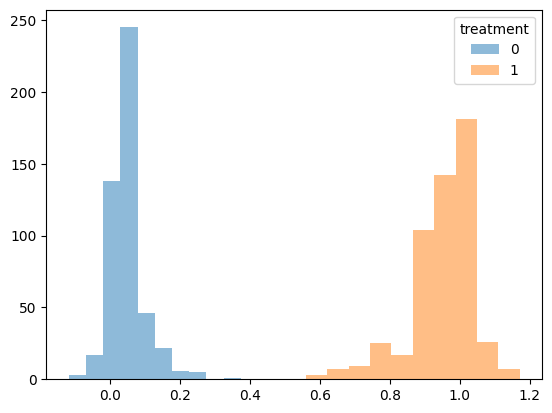

In [38]:
df_ps = pd.DataFrame({'ps':xb_fit.reshape(n,), 'treat':z})

for key, df in df_ps.groupby('treat'):
    color = 'Orange' if key == 1 else 'Blue'
    plt.hist(df['ps'], label=key, alpha=0.5)
plt.legend(title='treatment')

In [39]:
# append the fitted propensity scores to the original matrix
X1 = np.hstack((xb_fit, X))
d_p = X1.shape[1]

## XBCF fit

In [40]:
# XBCF parameters
sweeps = 10000
burn = 2000
p_cat = 6
trees_pr = 30
trees_trt = 10

In [41]:
# number of categorical variable are the only mandatory inputs
model = XBCF(
    num_sweeps=sweeps,
    burnin=burn,
    max_depth=250,
    num_trees_pr=trees_pr,
    num_trees_trt=trees_trt,
    mtry_pr=d_p,
    mtry_trt=d_t,
    num_cutpoints=100,
    Nmin=1,
    p_categorical_pr=p_cat,
    p_categorical_trt=p_cat,
    #tau_pr= 0.6 * np.var(y) / trees_pr,
    #tau_trt= 0.1 * np.var(y) / trees_trt,
    #no_split_penality="auto",
    #parallel=True,
    set_random_seed=True,
    random_seed=1013,
    #verbose=True, # 機能していない
    #standardize_target=True
)

In [42]:
start = time.time()
obj = model.fit(X, X1, y, z)
end = time.time()
print("seconds elapsed XBCF: ", end - start)

seconds elapsed XBCF:  165.24070596694946


## 結果

In [43]:
b = obj.b.transpose() # shape (2,sweeps)
a = obj.a.transpose() # shape (1,sweeps)

thats = obj.tauhats * (b[1] - b[0]) # shape (n, sweeps). これはobj.tauhats_adjusted と等価
thats_mean = np.mean(thats[:, (burn) : (sweeps - 1)], axis=1) # shape (n,)

# 結果可視化用の df を作成
df_vis = df_covar.copy()
df_vis['treat'] = z
df_vis['y'] = y
df_vis['tau'] = thats_mean

<Axes: >

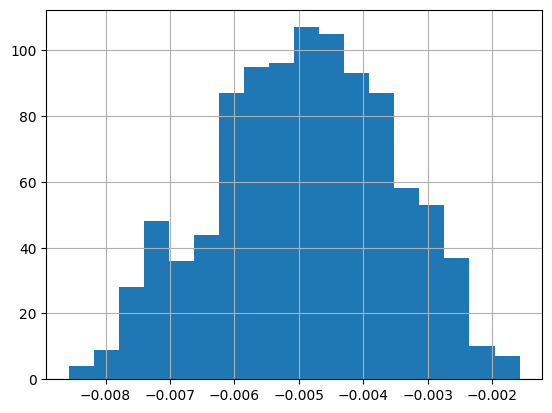

In [44]:
df_vis['tau'].hist(bins='auto')

Text(0.5, 1.0, 'invalsi & class size')

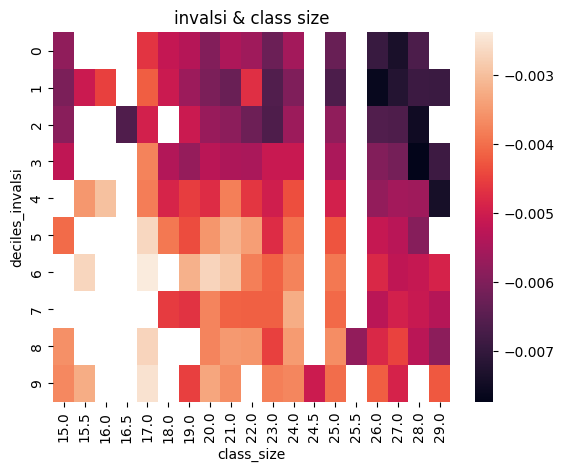

In [45]:
# heatmap
df_vis['deciles_invalsi'] = pd.qcut(df_vis['stdinvalsiI'], q=10, labels=False)
df_heatmap = pd.pivot_table(data=df_vis, index='deciles_invalsi', columns='class_size', values='tau')
sns.heatmap(df_heatmap)
plt.title('invalsi & class size')

Text(0.5, 1.0, 'Female')

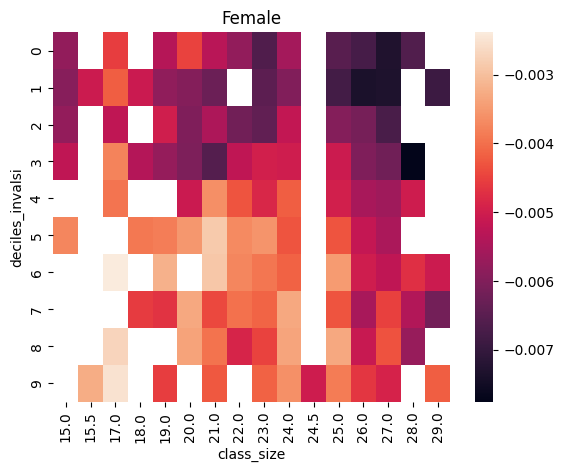

In [46]:
# heatmap
df_vis['deciles_invalsi'] = pd.qcut(df_vis['stdinvalsiI'], q=10, labels=False)
df_heatmap = pd.pivot_table(data=df_vis[df_vis['female']==1], index='deciles_invalsi', columns='class_size', values='tau')
sns.heatmap(df_heatmap)
plt.title('Female')

Text(0.5, 1.0, 'Male')

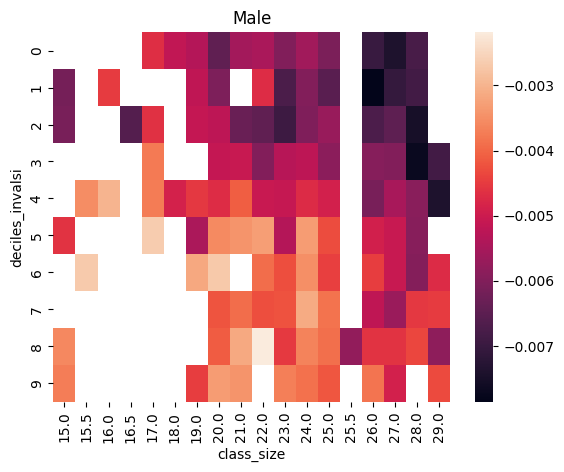

In [47]:
# heatmap
df_vis['deciles_invalsi'] = pd.qcut(df_vis['stdinvalsiI'], q=10, labels=False)
df_heatmap = pd.pivot_table(data=df_vis[df_vis['female']==0], index='deciles_invalsi', columns='class_size', values='tau')
sns.heatmap(df_heatmap)
plt.title('Male')

# 分析 4

変数を増やす

In [55]:
df = pd.read_stata(fileloc)
df = df[df['program_c']==1]
df = df.drop(df[df['program']==1].index)

In [56]:
df = df[df['potential_program']==1]

In [57]:
quan_col = [ 'stdinvalsiI', 'stdinvalsiI_2', 'class_size', 'perc_imm', 'school_size', 'school_code']
qual_col = ['female', 'immigrato_prima_gen', 'prov1', 'prov2', 'prov3', 'prov4', 'prov5', 'bluemother', 'whitemother', 'unempmother', 
            'homemother', 'bluefather', 'whitefather', 'unempfather', 'homefather', 'educmotherI', 'educmotherII', 'educmotherIII', 
            'educfatherI', 'educfatherII', 'educfatherIII', 'Romania', 'Marocco', 'Filippine', 'Albania', 'Peru', 'Ecuador', 'Cina',
            ]

variables = ['treat_c'] + quan_col + qual_col

In [58]:
df = df[variables+outputs].reset_index(drop=True).copy()

In [59]:
df = pd.concat([
    df['treat_c'],
    df[quan_col],
    df[outputs],
    df[qual_col].fillna(value=10000.)
], axis=1)

In [60]:
df_nona = df.dropna().reset_index(drop=True).copy()

In [54]:
# xbcf 用に共変量の並びを変える
df_covar = \
df_nona.reindex(
    columns=np.concatenate([
                quan_col,
                qual_col,
            ])
)
df_covar

,stdinvalsiI,stdinvalsiI_2,class_size,perc_imm,school_size,school_code,female,immigrato_prima_gen,prov1,prov2,...,educfatherI,educfatherII,educfatherIII,Romania,Marocco,Filippine,Albania,Peru,Ecuador,Cina
0,-1.502311,2.256938,25.0,0.240000,125.0,83.0,0.0,1.0,1.0,0.0,...,10000.0,10000.0,10000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.591522,2.532943,27.0,0.370370,159.0,91.0,0.0,1.0,0.0,0.0,...,10000.0,10000.0,10000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.093905,0.008818,27.0,0.296296,125.0,25.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.139284,1.297968,26.0,0.230769,150.0,85.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,-1.495939,2.237832,24.0,0.458333,139.0,80.0,1.0,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,-0.642058,0.412239,23.0,0.173913,307.0,47.0,0.0,1.0,0.0,0.0,...,10000.0,10000.0,10000.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1000,-1.725358,2.976862,25.0,0.360000,221.0,3.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,-0.622840,0.387929,25.0,0.240000,216.0,50.0,0.0,1.0,0.0,0.0,...,10000.0,10000.0,10000.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1002,-0.744014,0.553557,26.0,0.384615,165.0,86.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## 変数定義

In [55]:
y = df_nona['stdinvalsiIII'].to_numpy()
z = df_nona['treat_c'].to_numpy()
X = df_covar.to_numpy()
z = z.astype(np.int32)

In [56]:
d_t = X.shape[1]
n = X.shape[0]

## propensity score estimation

In [57]:
start = time.time()
xbt = XBART(num_trees=100, num_sweeps=40, burnin=15)
xb_fit = xbt.fit_predict(X, z, X)
xb_fit = xb_fit.reshape((n, 1))

end = time.time()
print("second elapsed XBART for pihat: ", end - start)

second elapsed XBART for pihat:  4.156078815460205


Text(0, 0.5, 'frequency')

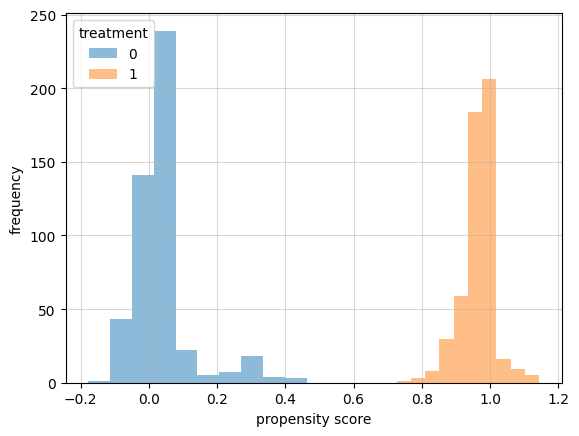

In [58]:
df_ps = pd.DataFrame({'ps':xb_fit.reshape(n,), 'treat':z})

for key, df in df_ps.groupby('treat'):
    color = 'Orange' if key == 1 else 'Blue'
    plt.hist(df['ps'], label=key, alpha=0.5)
plt.legend(title='treatment')
plt.grid(alpha=0.5)
plt.xlabel('propensity score')
plt.ylabel('frequency')

In [59]:
# append the fitted propensity scores to the original matrix
X1 = np.hstack((xb_fit, X))
d_p = X1.shape[1]

## XBCF fit

In [60]:
# XBCF parameters
sweeps = 10000
burn = 2000
p_cat = len(qual_col)
trees_pr = 30
trees_trt = 10

In [61]:
# number of categorical variable are the only mandatory inputs
model = XBCF(
    num_sweeps=sweeps,
    burnin=burn,
    max_depth=250,
    num_trees_pr=trees_pr,
    num_trees_trt=trees_trt,
    mtry_pr=d_p,
    mtry_trt=d_t,
    num_cutpoints=100,
    Nmin=1,
    p_categorical_pr=p_cat,
    p_categorical_trt=p_cat,
    #tau_pr= 0.6 * np.var(y) / trees_pr,
    #tau_trt= 0.1 * np.var(y) / trees_trt,
    #no_split_penality="auto",
    #parallel=True,
    set_random_seed=True,
    random_seed=1013,
    #verbose=True, # 機能していない
    #standardize_target=True
)

In [62]:
start = time.time()
obj = model.fit(X, X1, y, z)
end = time.time()
print("seconds elapsed XBCF: ", end - start)

seconds elapsed XBCF:  297.93582701683044


## 結果

In [63]:
b = obj.b.transpose() # shape (2,sweeps)
a = obj.a.transpose() # shape (1,sweeps)

thats = obj.tauhats * (b[1] - b[0]) # shape (n, sweeps). これはobj.tauhats_adjusted と等価
thats_mean = np.mean(thats[:, (burn) : (sweeps - 1)], axis=1) # shape (n,)

# 結果可視化用の df を作成
df_vis = df_covar.copy()
df_vis['treat'] = z
df_vis['y'] = y
df_vis['tau'] = thats_mean

<Axes: >

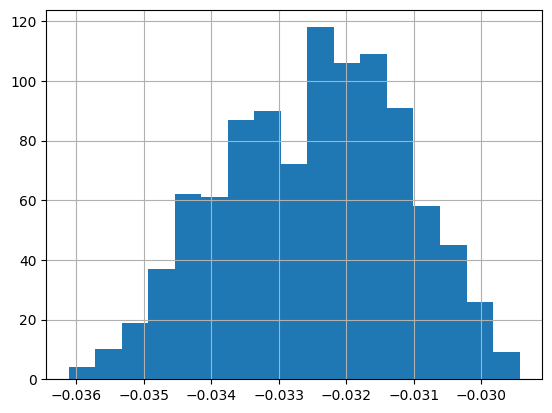

In [64]:
df_vis['tau'].hist(bins='auto')

Text(0.5, 1.0, 'invalsi & class size')

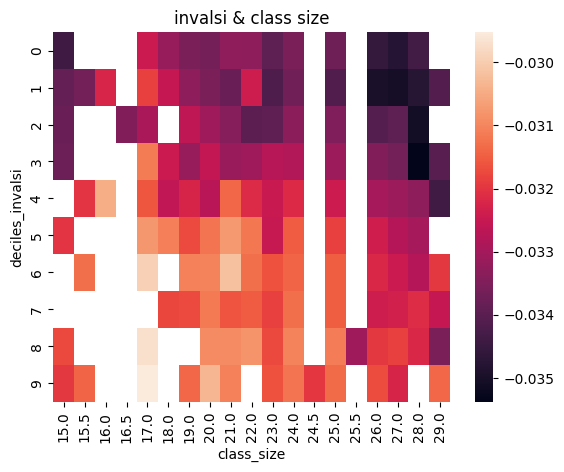

In [65]:
# heatmap
df_vis['deciles_invalsi'] = pd.qcut(df_vis['stdinvalsiI'], q=10, labels=False)
df_heatmap = pd.pivot_table(data=df_vis, index='deciles_invalsi', columns='class_size', values='tau')
sns.heatmap(df_heatmap)
plt.title('invalsi & class size')

'Romania', 'Marocco', 'Filippine', 'Albania', 'Peru', 'Ecuador', 'Cina'

<Axes: xlabel='Romania', ylabel='deciles_invalsi'>

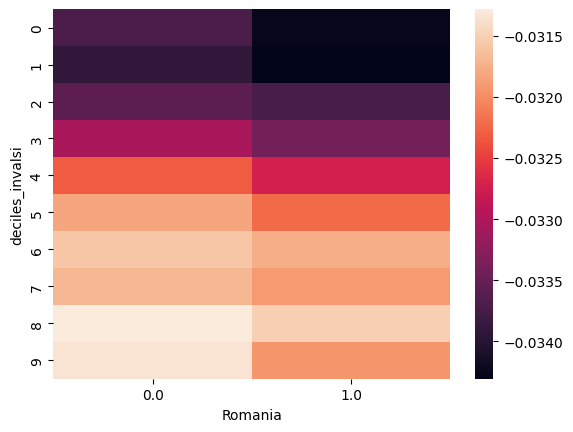

In [67]:
# heatmap
df_heatmap = pd.pivot_table(data=df_vis, index='deciles_invalsi', columns='Romania', values='tau')
sns.heatmap(df_heatmap)

<Axes: xlabel='Marocco', ylabel='deciles_invalsi'>

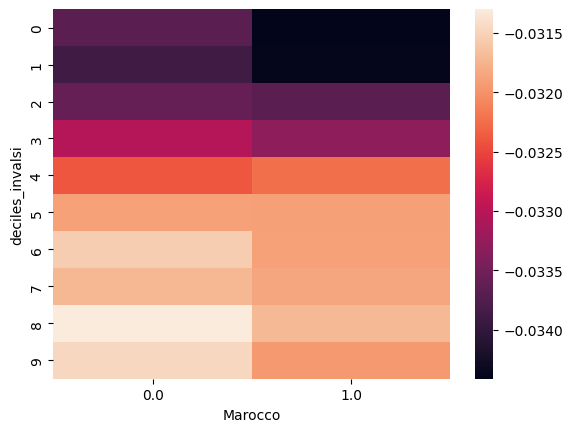

In [68]:
# heatmap
df_heatmap = pd.pivot_table(data=df_vis, index='deciles_invalsi', columns='Marocco', values='tau')
sns.heatmap(df_heatmap)

<Axes: xlabel='Filippine', ylabel='deciles_invalsi'>

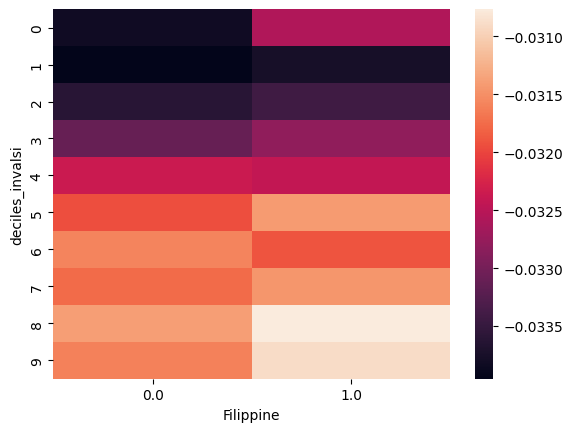

In [ ]:
# heatmap
df_heatmap = pd.pivot_table(data=df_vis, index='deciles_invalsi', columns='Filippine', values='tau')
sns.heatmap(df_heatmap)

<Axes: xlabel='Albania', ylabel='deciles_invalsi'>

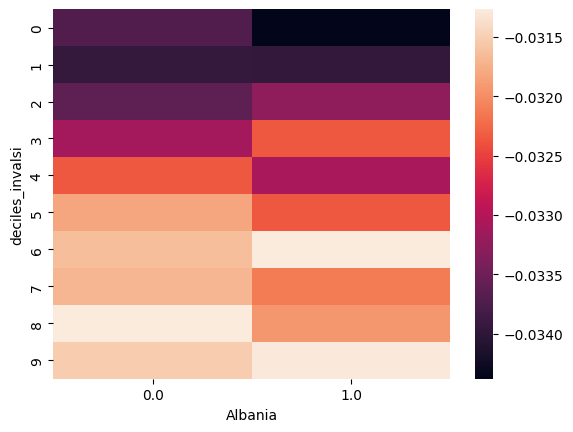

In [69]:
# heatmap
df_heatmap = pd.pivot_table(data=df_vis, index='deciles_invalsi', columns='Albania', values='tau')
sns.heatmap(df_heatmap)

<Axes: xlabel='Peru', ylabel='deciles_invalsi'>

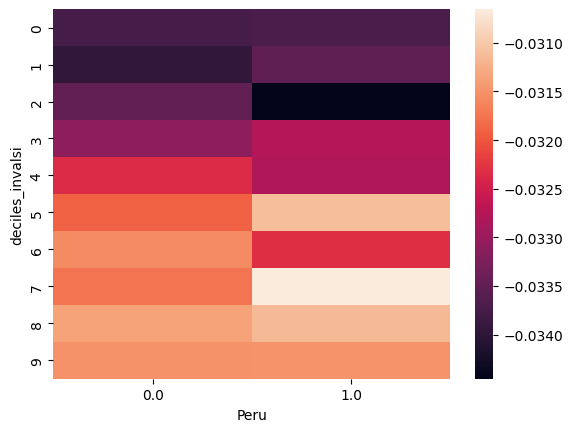

In [70]:
# heatmap
df_heatmap = pd.pivot_table(data=df_vis, index='deciles_invalsi', columns='Peru', values='tau')
sns.heatmap(df_heatmap)

<Axes: xlabel='Ecuador', ylabel='deciles_invalsi'>

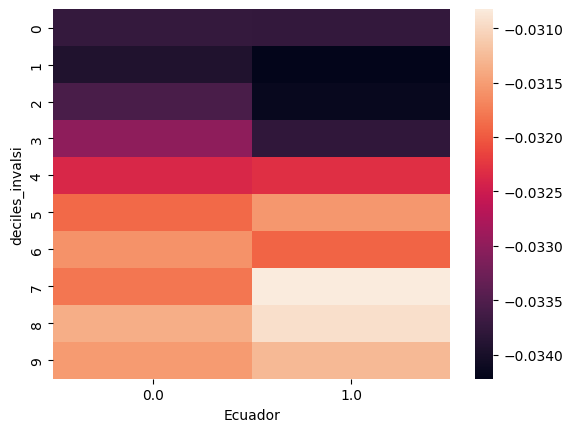

In [71]:
# heatmap
df_heatmap = pd.pivot_table(data=df_vis, index='deciles_invalsi', columns='Ecuador', values='tau')
sns.heatmap(df_heatmap)

<Axes: xlabel='Cina', ylabel='deciles_invalsi'>

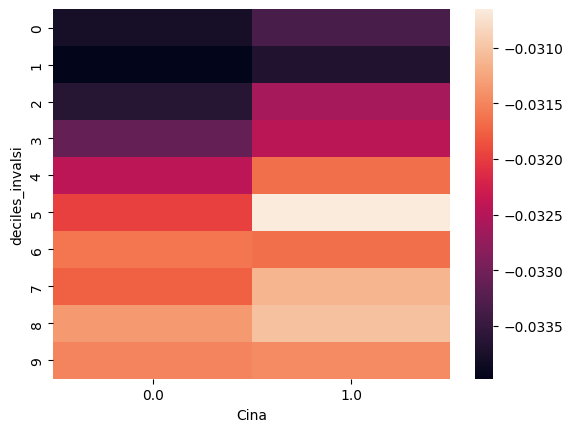

In [72]:
# heatmap
df_heatmap = pd.pivot_table(data=df_vis, index='deciles_invalsi', columns='Cina', values='tau')
sns.heatmap(df_heatmap)

invalsiI, invalsiIII を見る

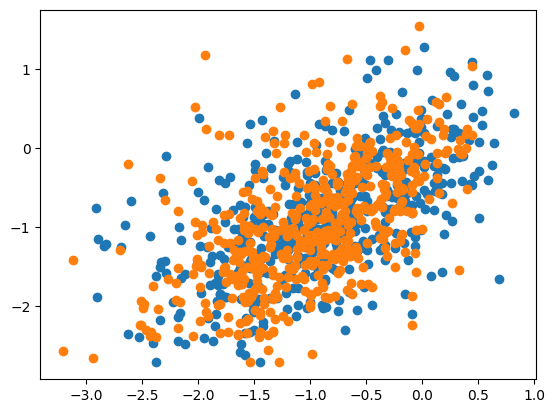

In [75]:
fig, ax = plt.subplots()

ax.scatter(x=df_nona.loc[df_nona['treat_c']==0, 'stdinvalsiI'], y=df_nona.loc[df_nona['treat_c']==0, 'stdinvalsiIII'])
ax.scatter(x=df_nona.loc[df_nona['treat_c']==1, 'stdinvalsiI'], y=df_nona.loc[df_nona['treat_c']==1, 'stdinvalsiIII'])

class_size, invalsiIII を見る

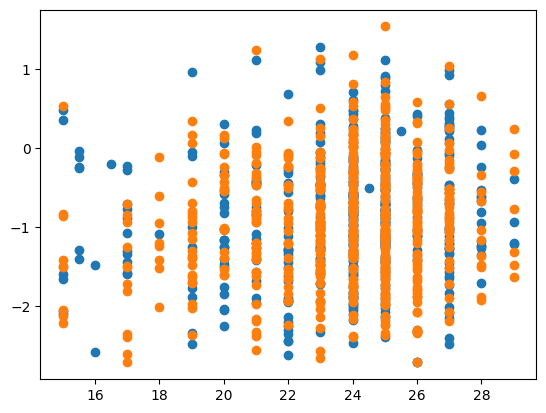

In [76]:
fig, ax = plt.subplots()

ax.scatter(x=df_nona.loc[df_nona['treat_c']==0, 'class_size'], y=df_nona.loc[df_nona['treat_c']==0, 'stdinvalsiIII'])
ax.scatter(x=df_nona.loc[df_nona['treat_c']==1, 'class_size'], y=df_nona.loc[df_nona['treat_c']==1, 'stdinvalsiIII'])

school_code, invalsiIII を見る

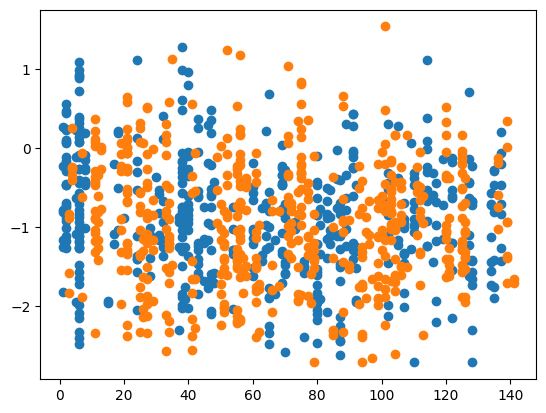

In [77]:
fig, ax = plt.subplots()

ax.scatter(x=df_nona.loc[df_nona['treat_c']==0, 'school_code'], y=df_nona.loc[df_nona['treat_c']==0, 'stdinvalsiIII'])
ax.scatter(x=df_nona.loc[df_nona['treat_c']==1, 'school_code'], y=df_nona.loc[df_nona['treat_c']==1, 'stdinvalsiIII'])

school_size, invalsi

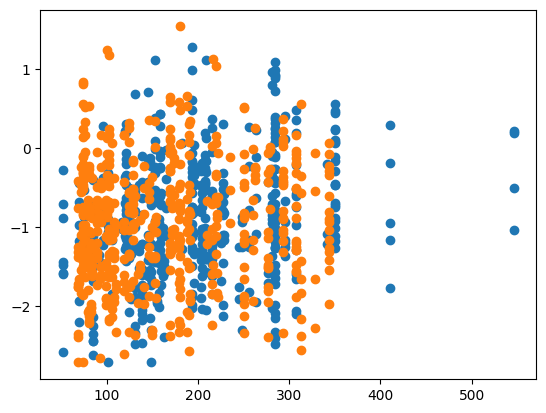

In [61]:
fig, ax = plt.subplots()

ax.scatter(x=df_nona.loc[df_nona['treat_c']==0, 'school_size'], y=df_nona.loc[df_nona['treat_c']==0, 'stdinvalsiIII'])
ax.scatter(x=df_nona.loc[df_nona['treat_c']==1, 'school_size'], y=df_nona.loc[df_nona['treat_c']==1, 'stdinvalsiIII'])

prov, invalsiIII を調べる

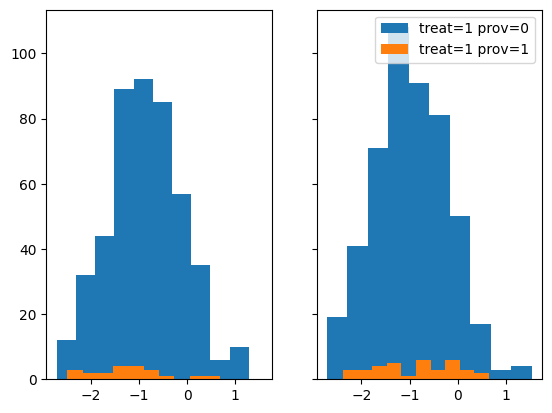

In [124]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)

axes[0].hist(df_nona.query("treat_c==0").query("prov2==0")['stdinvalsiIII'], label='treat=0 prov=0')
axes[0].hist(df_nona.query("treat_c==0").query("prov2==1")['stdinvalsiIII'], label='treat=0 orov=1')
axes[1].hist(df_nona.query("treat_c==1").query("prov2==0")['stdinvalsiIII'], label='treat=1 prov=0')
axes[1].hist(df_nona.query("treat_c==1").query("prov2==1")['stdinvalsiIII'], label='treat=1 prov=1')
plt.legend()

perc_imm, invalsiIII を調べる

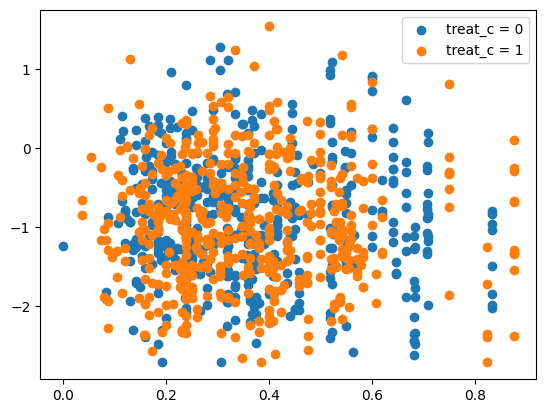

In [137]:
fig, ax = plt.subplots()

ax.scatter(x=df_nona.loc[df_nona['treat_c']==0, 'perc_imm'], y=df_nona.loc[df_nona['treat_c']==0, 'stdinvalsiIII'], label='treat_c = 0')
ax.scatter(x=df_nona.loc[df_nona['treat_c']==1, 'perc_imm'], y=df_nona.loc[df_nona['treat_c']==1, 'stdinvalsiIII'], label='treat_c = 1')
plt.legend()

school_code　が non-overlap の原因か調べる

In [81]:
df_overlap = pd.read_stata(fileloc)
df_overlap = df_overlap[df_overlap['program_c']==1]
df_overlap = df_overlap.drop(df_overlap[df_overlap['program']==1].index)

In [82]:
df_overlap = df_overlap[df_overlap['potential_program']==1]

In [83]:
quan_col_overlap = [ 'stdinvalsiI', 'stdinvalsiI_2', 'class_size', 'perc_imm', 'school_size']
qual_col_overlap = ['female', 'immigrato_prima_gen', 'prov1', 'prov2', 'prov3', 'prov4', 'prov5', 'bluemother', 'whitemother', 'unempmother', 
            'homemother', 'bluefather', 'whitefather', 'unempfather', 'homefather', 'educmotherI', 'educmotherII', 'educmotherIII', 
            'educfatherI', 'educfatherII', 'educfatherIII', 'Romania', 'Marocco', 'Filippine', 'Albania', 'Peru', 'Ecuador', 'Cina',
            ]

variables_o = ['treat_c'] + quan_col_overlap + qual_col_overlap

In [84]:
df_overlap = df_overlap[variables_o+outputs].reset_index(drop=True).copy()

In [85]:
df_overlap = pd.concat([
    df_overlap['treat_c'],
    df_overlap[quan_col_overlap],
    df_overlap[outputs],
    df_overlap[qual_col_overlap].fillna(value=10000.)
], axis=1)

In [86]:
df_o_nona = df_overlap.dropna().reset_index(drop=True).copy()

In [87]:
# xbcf 用に共変量の並びを変える
df_covar_overlap = \
df_o_nona.reindex(
    columns=np.concatenate([
                quan_col_overlap,
                qual_col_overlap,
            ])
)
df_covar_overlap

,stdinvalsiI,stdinvalsiI_2,class_size,perc_imm,school_size,female,immigrato_prima_gen,prov1,prov2,prov3,...,educfatherI,educfatherII,educfatherIII,Romania,Marocco,Filippine,Albania,Peru,Ecuador,Cina
0,-1.502311,2.256938,25.0,0.240000,125.0,0.0,1.0,1.0,0.0,0.0,...,10000.0,10000.0,10000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.591522,2.532943,27.0,0.370370,159.0,0.0,1.0,0.0,0.0,1.0,...,10000.0,10000.0,10000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.093905,0.008818,27.0,0.296296,125.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.139284,1.297968,26.0,0.230769,150.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,-1.495939,2.237832,24.0,0.458333,139.0,1.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,-0.642058,0.412239,23.0,0.173913,307.0,0.0,1.0,0.0,0.0,1.0,...,10000.0,10000.0,10000.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1000,-1.725358,2.976862,25.0,0.360000,221.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,-0.622840,0.387929,25.0,0.240000,216.0,0.0,1.0,0.0,0.0,0.0,...,10000.0,10000.0,10000.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1002,-0.744014,0.553557,26.0,0.384615,165.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [88]:
y2 = df_o_nona['stdinvalsiIII'].to_numpy()
z2 = df_o_nona['treat_c'].to_numpy()
X2 = df_covar_overlap.to_numpy()
z2 = z2.astype(np.int32)

In [89]:
start = time.time()
xbt2 = XBART(num_trees=100, num_sweeps=40, burnin=15)
xb_fit2 = xbt2.fit_predict(X2, z2, X2)
xb_fit2 = xb_fit2.reshape((n, 1))

end = time.time()
print("second elapsed XBART for pihat: ", end - start)

second elapsed XBART for pihat:  4.539781093597412


Text(0, 0.5, 'frequency')

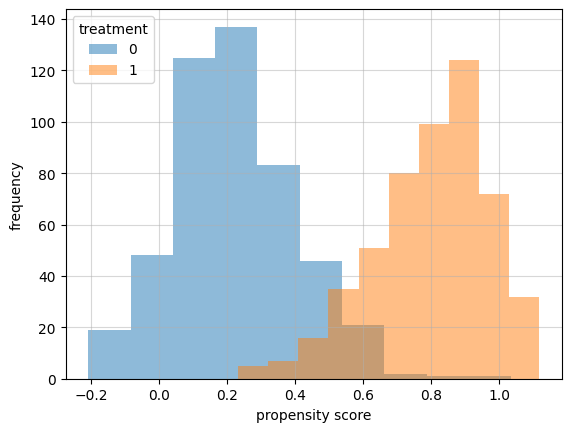

In [90]:
df_ps2 = pd.DataFrame({'ps':xb_fit2.reshape(n,), 'treat':z2})

for key, df in df_ps2.groupby('treat'):
    color = 'Orange' if key == 1 else 'Blue'
    plt.hist(df['ps'], label=key, alpha=0.5)
plt.legend(title='treatment')
plt.grid(alpha=0.5)
plt.xlabel('propensity score')
plt.ylabel('frequency')

perc_imm　が non-overlap の原因か調べる.  
既に school_code は差し引かれている

In [138]:
df_overlap = pd.read_stata(fileloc)
df_overlap = df_overlap[df_overlap['program_c']==1]
df_overlap = df_overlap.drop(df_overlap[df_overlap['program']==1].index)

In [139]:
df_overlap = df_overlap[df_overlap['potential_program']==1]

In [140]:
quan_col_overlap = [ 'stdinvalsiI', 'stdinvalsiI_2', 'class_size', 'school_size']
qual_col_overlap = ['female', 'immigrato_prima_gen', 'prov1', 'prov2', 'prov3', 'prov4', 'prov5', 'bluemother', 'whitemother', 'unempmother', 
            'homemother', 'bluefather', 'whitefather', 'unempfather', 'homefather', 'educmotherI', 'educmotherII', 'educmotherIII', 
            'educfatherI', 'educfatherII', 'educfatherIII', 'Romania', 'Marocco', 'Filippine', 'Albania', 'Peru', 'Ecuador', 'Cina',
            ]

variables_o = ['treat_c'] + quan_col_overlap + qual_col_overlap

In [141]:
df_overlap = df_overlap[variables_o+outputs].reset_index(drop=True).copy()

In [142]:
df_overlap = pd.concat([
    df_overlap['treat_c'],
    df_overlap[quan_col_overlap],
    df_overlap[outputs],
    df_overlap[qual_col_overlap].fillna(value=10000.)
], axis=1)

In [143]:
df_o_nona = df_overlap.dropna().reset_index(drop=True).copy()

In [144]:
# xbcf 用に共変量の並びを変える
df_covar_overlap = \
df_o_nona.reindex(
    columns=np.concatenate([
                quan_col_overlap,
                qual_col_overlap,
            ])
)
df_covar_overlap

,stdinvalsiI,stdinvalsiI_2,class_size,school_size,female,immigrato_prima_gen,prov1,prov2,prov3,prov4,...,educfatherI,educfatherII,educfatherIII,Romania,Marocco,Filippine,Albania,Peru,Ecuador,Cina
0,-1.502311,2.256938,25.0,125.0,0.0,1.0,1.0,0.0,0.0,0.0,...,10000.0,10000.0,10000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.591522,2.532943,27.0,159.0,0.0,1.0,0.0,0.0,1.0,0.0,...,10000.0,10000.0,10000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.093905,0.008818,27.0,125.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.139284,1.297968,26.0,150.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,-1.495939,2.237832,24.0,139.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,-0.642058,0.412239,23.0,307.0,0.0,1.0,0.0,0.0,1.0,0.0,...,10000.0,10000.0,10000.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1000,-1.725358,2.976862,25.0,221.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,-0.622840,0.387929,25.0,216.0,0.0,1.0,0.0,0.0,0.0,1.0,...,10000.0,10000.0,10000.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1002,-0.744014,0.553557,26.0,165.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [145]:
y2 = df_o_nona['stdinvalsiIII'].to_numpy()
z2 = df_o_nona['treat_c'].to_numpy()
X2 = df_covar_overlap.to_numpy()
z2 = z2.astype(np.int32)

In [146]:
start = time.time()
xbt2 = XBART(num_trees=100, num_sweeps=40, burnin=15)
xb_fit2 = xbt2.fit_predict(X2, z2, X2)
xb_fit2 = xb_fit2.reshape((n, 1))

end = time.time()
print("second elapsed XBART for pihat: ", end - start)

second elapsed XBART for pihat:  4.655086040496826


Text(0, 0.5, 'frequency')

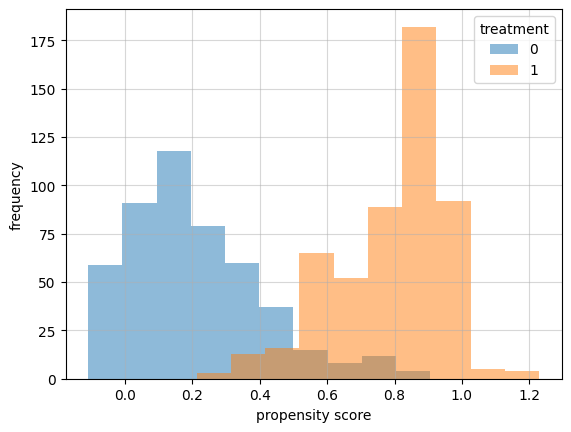

In [147]:
df_ps2 = pd.DataFrame({'ps':xb_fit2.reshape(n,), 'treat':z2})

for key, df in df_ps2.groupby('treat'):
    color = 'Orange' if key == 1 else 'Blue'
    plt.hist(df['ps'], label=key, alpha=0.5)
plt.legend(title='treatment')
plt.grid(alpha=0.5)
plt.xlabel('propensity score')
plt.ylabel('frequency')

school_size が non-overlap の原因か調べる.  
school_code, perc_imm は既に差し引かれている

In [72]:
df_overlap = pd.read_stata(fileloc)
df_overlap = df_overlap[df_overlap['program_c']==1]
df_overlap = df_overlap.drop(df_overlap[df_overlap['program']==1].index)

In [74]:
df_overlap = df_overlap[df_overlap['potential_program']==1]

In [75]:
quan_col_overlap = [ 'stdinvalsiI', 'stdinvalsiI_2', 'class_size',]
qual_col_overlap = ['female', 'immigrato_prima_gen', 'prov1', 'prov2', 'prov3', 'prov4', 'prov5', 'bluemother', 'whitemother', 'unempmother', 
            'homemother', 'bluefather', 'whitefather', 'unempfather', 'homefather', 'educmotherI', 'educmotherII', 'educmotherIII', 
            'educfatherI', 'educfatherII', 'educfatherIII', 'Romania', 'Marocco', 'Filippine', 'Albania', 'Peru', 'Ecuador', 'Cina',
            ]

variables_o = ['treat_c'] + quan_col_overlap + qual_col_overlap

In [76]:
df_overlap = df_overlap[variables_o+outputs].reset_index(drop=True).copy()

In [77]:
df_overlap = pd.concat([
    df_overlap['treat_c'],
    df_overlap[quan_col_overlap],
    df_overlap[outputs],
    df_overlap[qual_col_overlap].fillna(value=10000.)
], axis=1)

In [78]:
df_o_nona = df_overlap.dropna().reset_index(drop=True).copy()

In [79]:
# xbcf 用に共変量の並びを変える
df_covar_overlap = \
df_o_nona.reindex(
    columns=np.concatenate([
                quan_col_overlap,
                qual_col_overlap,
            ])
)
df_covar_overlap

,stdinvalsiI,stdinvalsiI_2,class_size,female,immigrato_prima_gen,prov1,prov2,prov3,prov4,prov5,...,educfatherI,educfatherII,educfatherIII,Romania,Marocco,Filippine,Albania,Peru,Ecuador,Cina
0,-1.502311,2.256938,25.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,10000.0,10000.0,10000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.591522,2.532943,27.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,10000.0,10000.0,10000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.093905,0.008818,27.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.139284,1.297968,26.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,-1.495939,2.237832,24.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,-0.642058,0.412239,23.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,10000.0,10000.0,10000.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1000,-1.725358,2.976862,25.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,-0.622840,0.387929,25.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,10000.0,10000.0,10000.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1002,-0.744014,0.553557,26.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [80]:
y2 = df_o_nona['stdinvalsiIII'].to_numpy()
z2 = df_o_nona['treat_c'].to_numpy()
X2 = df_covar_overlap.to_numpy()
z2 = z2.astype(np.int32)

In [81]:
start = time.time()
xbt2 = XBART(num_trees=100, num_sweeps=40, burnin=15)
xb_fit2 = xbt2.fit_predict(X2, z2, X2)
xb_fit2 = xb_fit2.reshape((n, 1))

end = time.time()
print("second elapsed XBART for pihat: ", end - start)

second elapsed XBART for pihat:  4.368834972381592


Text(0, 0.5, 'frequency')

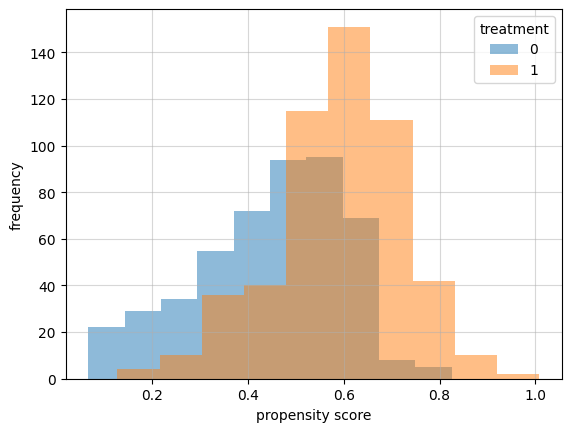

In [82]:
df_ps2 = pd.DataFrame({'ps':xb_fit2.reshape(n,), 'treat':z2})

for key, df in df_ps2.groupby('treat'):
    color = 'Orange' if key == 1 else 'Blue'
    plt.hist(df['ps'], label=key, alpha=0.5)
plt.legend(title='treatment')
plt.grid(alpha=0.5)
plt.xlabel('propensity score')
plt.ylabel('frequency')

# 分析5

分析４から school_code, perc_imm, school_size を除去

In [83]:
df_overlap = pd.read_stata(fileloc)
df_overlap = df_overlap[df_overlap['program_c']==1]
df_overlap = df_overlap.drop(df_overlap[df_overlap['program']==1].index)

In [84]:
df_overlap = df_overlap[df_overlap['potential_program']==1]

In [85]:
quan_col_overlap = [ 'stdinvalsiI', 'stdinvalsiI_2', 'class_size',]
qual_col_overlap = ['female', 'immigrato_prima_gen', 'prov1', 'prov2', 'prov3', 'prov4', 'prov5', 'bluemother', 'whitemother', 'unempmother', 
            'homemother', 'bluefather', 'whitefather', 'unempfather', 'homefather', 'educmotherI', 'educmotherII', 'educmotherIII', 
            'educfatherI', 'educfatherII', 'educfatherIII', 'Romania', 'Marocco', 'Filippine', 'Albania', 'Peru', 'Ecuador', 'Cina',
            ]

variables_o = ['treat_c'] + quan_col_overlap + qual_col_overlap

In [86]:
outputs = ['lictec2', 'fail', 'stdinvalsiIII', 'recc_lictec2']

In [87]:
df_overlap = df_overlap[variables_o+outputs].reset_index(drop=True).copy()

In [88]:
df_overlap = pd.concat([
    df_overlap['treat_c'],
    df_overlap[quan_col_overlap],
    df_overlap[outputs],
    df_overlap[qual_col_overlap].fillna(value=10000.)
], axis=1)

In [89]:
df_o_nona = df_overlap.dropna().reset_index(drop=True).copy()

In [90]:
# xbcf 用に共変量の並びを変える
df_covar_overlap = \
df_o_nona.reindex(
    columns=np.concatenate([
                quan_col_overlap,
                qual_col_overlap,
            ])
)
df_covar_overlap

,stdinvalsiI,stdinvalsiI_2,class_size,female,immigrato_prima_gen,prov1,prov2,prov3,prov4,prov5,...,educfatherI,educfatherII,educfatherIII,Romania,Marocco,Filippine,Albania,Peru,Ecuador,Cina
0,-1.502311,2.256938,25.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,10000.0,10000.0,10000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.591522,2.532943,27.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,10000.0,10000.0,10000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.093905,0.008818,27.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.139284,1.297968,26.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,-1.495939,2.237832,24.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,-0.642058,0.412239,23.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,10000.0,10000.0,10000.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1000,-1.725358,2.976862,25.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,-0.622840,0.387929,25.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,10000.0,10000.0,10000.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1002,-0.744014,0.553557,26.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [91]:
y2 = df_o_nona['stdinvalsiIII'].to_numpy()
z2 = df_o_nona['treat_c'].to_numpy()
X2 = df_covar_overlap.to_numpy()
z2 = z2.astype(np.int32)

In [92]:
d_t = X2.shape[1]
n = X2.shape[0]

In [93]:
start = time.time()
xbt2 = XBART(num_trees=100, num_sweeps=40, burnin=15)
xb_fit2 = xbt2.fit_predict(X2, z2, X2)
xb_fit2 = xb_fit2.reshape((n, 1))

end = time.time()
print("second elapsed XBART for pihat: ", end - start)

second elapsed XBART for pihat:  4.275909185409546


Text(0, 0.5, 'frequency')

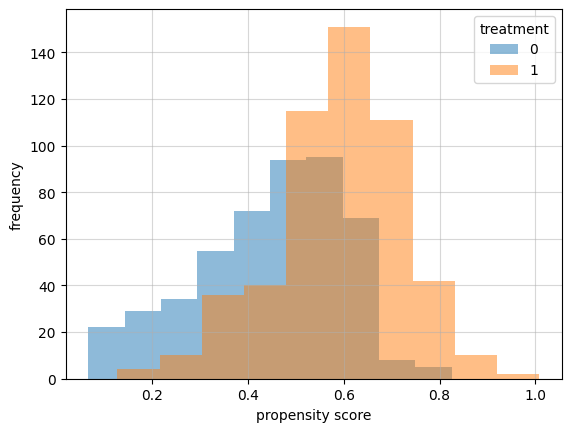

In [94]:
df_ps2 = pd.DataFrame({'ps':xb_fit2.reshape(n,), 'treat':z2})

for key, df in df_ps2.groupby('treat'):
    color = 'Orange' if key == 1 else 'Blue'
    plt.hist(df['ps'], label=key, alpha=0.5)
plt.legend(title='treatment')
plt.grid(alpha=0.5)
plt.xlabel('propensity score')
plt.ylabel('frequency')

In [95]:
# append the fitted propensity scores to the original matrix
X1 = np.hstack((xb_fit2, X2))
d_p = X1.shape[1]

## XBCF fit

In [96]:
# XBCF parameters
sweeps = 10000
burn = 2000
p_cat = len(qual_col_overlap)
trees_pr = 30
trees_trt = 10

In [97]:
# number of categorical variable are the only mandatory inputs
model = XBCF(
    num_sweeps=sweeps,
    burnin=burn,
    max_depth=250,
    num_trees_pr=trees_pr,
    num_trees_trt=trees_trt,
    mtry_pr=d_p,
    mtry_trt=d_t,
    num_cutpoints=100,
    Nmin=1,
    p_categorical_pr=p_cat,
    p_categorical_trt=p_cat,
    #tau_pr= 0.6 * np.var(y) / trees_pr,
    #tau_trt= 0.1 * np.var(y) / trees_trt,
    #no_split_penality="auto",
    #parallel=True,
    set_random_seed=True,
    random_seed=1013,
    #verbose=True, # 機能していない
    #standardize_target=True
)

In [98]:
start = time.time()
obj = model.fit(X2, X1, y2, z2)
end = time.time()
print("seconds elapsed XBCF: ", end - start)

seconds elapsed XBCF:  263.2925319671631


## 結果

In [99]:
thats = obj.tauhats_adjusted # shape (n, sweeps).
thats_mean = np.mean(thats[:, (burn) : (sweeps - 1)], axis=1) # shape (n,)

# 結果可視化用の df を作成
df_vis = df_covar_overlap.copy()
df_vis['treat'] = z2
df_vis['y'] = y2
df_vis['tau'] = thats_mean

<Axes: >

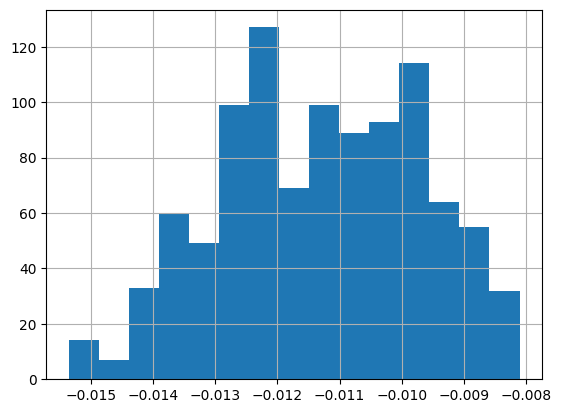

In [100]:
df_vis['tau'].hist(bins='auto')

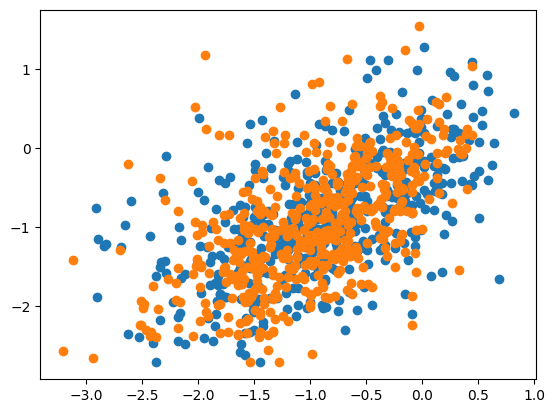

In [101]:
fig, ax = plt.subplots()

ax.scatter(x=df_o_nona.loc[df_o_nona['treat_c']==0, 'stdinvalsiI'], y=df_o_nona.loc[df_o_nona['treat_c']==0, 'stdinvalsiIII'])
ax.scatter(x=df_o_nona.loc[df_o_nona['treat_c']==1, 'stdinvalsiI'], y=df_o_nona.loc[df_o_nona['treat_c']==1, 'stdinvalsiIII'])

### 移民

<Axes: xlabel='Romania', ylabel='deciles_invalsi'>

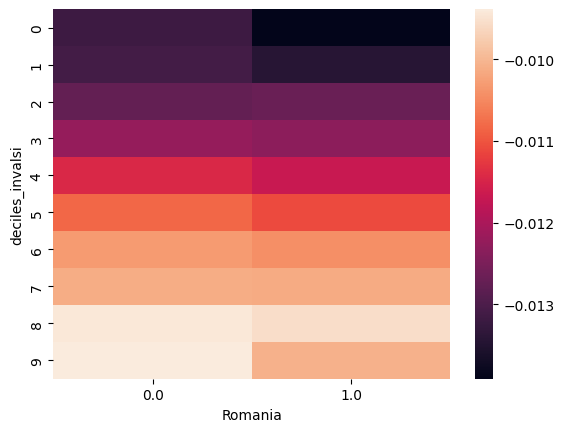

In [103]:
# heatmap
df_vis['deciles_invalsi'] = pd.qcut(df_vis['stdinvalsiI'], q=10, labels=False)
df_heatmap = pd.pivot_table(data=df_vis, index='deciles_invalsi', columns='Romania', values='tau')
sns.heatmap(df_heatmap)

<Axes: xlabel='Marocco', ylabel='deciles_invalsi'>

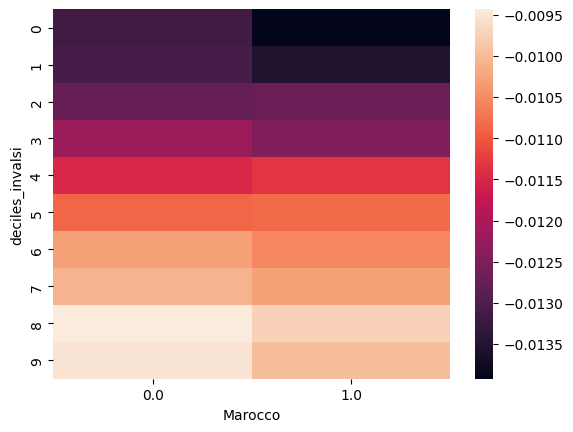

In [104]:
# heatmap
df_heatmap = pd.pivot_table(data=df_vis, index='deciles_invalsi', columns='Marocco', values='tau')
sns.heatmap(df_heatmap)

<Axes: xlabel='Filippine', ylabel='deciles_invalsi'>

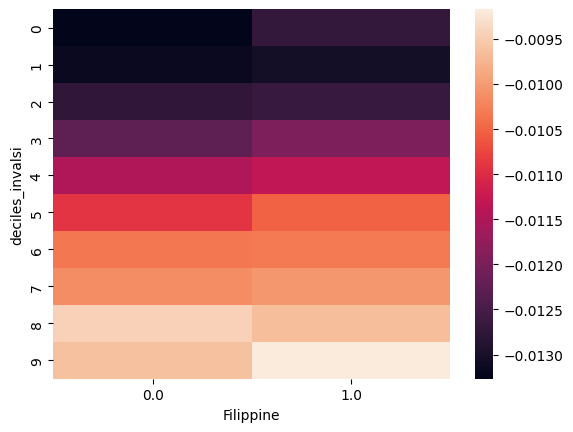

In [105]:
# heatmap
df_heatmap = pd.pivot_table(data=df_vis, index='deciles_invalsi', columns='Filippine', values='tau')
sns.heatmap(df_heatmap)

<Axes: xlabel='Albania', ylabel='deciles_invalsi'>

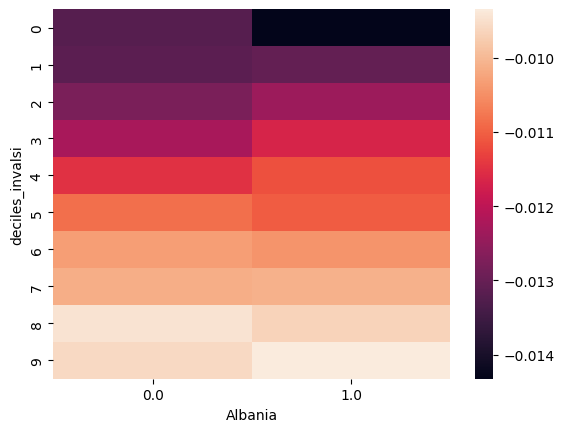

In [106]:
# heatmap
df_heatmap = pd.pivot_table(data=df_vis, index='deciles_invalsi', columns='Albania', values='tau')
sns.heatmap(df_heatmap)

<Axes: xlabel='Peru', ylabel='deciles_invalsi'>

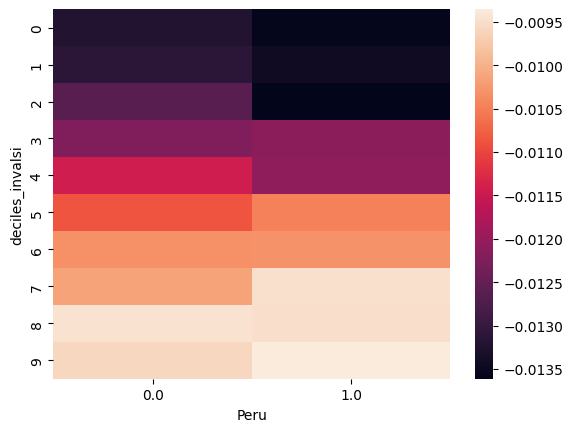

In [107]:
# heatmap
df_heatmap = pd.pivot_table(data=df_vis, index='deciles_invalsi', columns='Peru', values='tau')
sns.heatmap(df_heatmap)

<Axes: xlabel='Ecuador', ylabel='deciles_invalsi'>

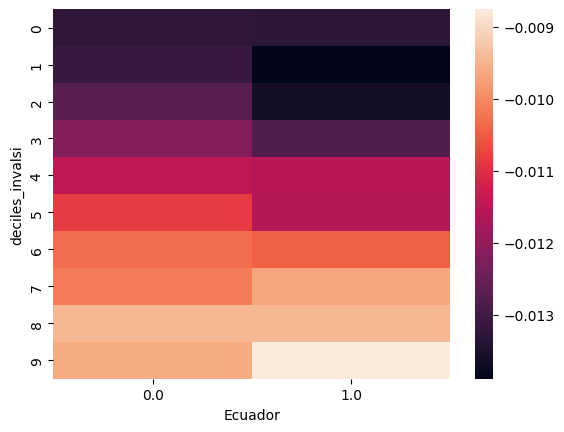

In [108]:
# heatmap
df_heatmap = pd.pivot_table(data=df_vis, index='deciles_invalsi', columns='Ecuador', values='tau')
sns.heatmap(df_heatmap)

<Axes: xlabel='Cina', ylabel='deciles_invalsi'>

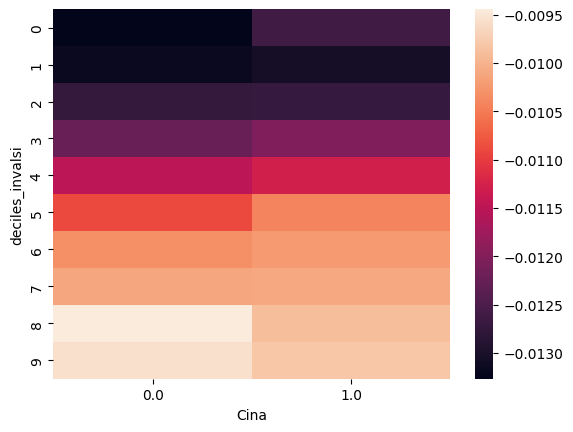

In [109]:
# heatmap
df_heatmap = pd.pivot_table(data=df_vis, index='deciles_invalsi', columns='Cina', values='tau')
sns.heatmap(df_heatmap)

### China

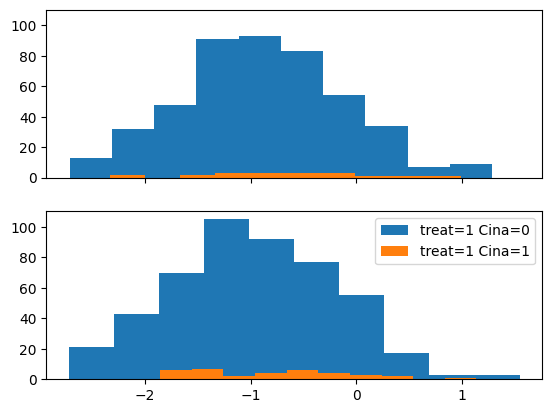

In [115]:
fig, axes = plt.subplots(2,1, sharex=True, sharey=True)

axes[0].hist(df_o_nona.query("treat_c==0").query("Cina==0")['stdinvalsiIII'], label='treat=0 Cina=0')
axes[0].hist(df_o_nona.query("treat_c==0").query("Cina==1")['stdinvalsiIII'], label='treat=0 Cina=1')
axes[1].hist(df_o_nona.query("treat_c==1").query("Cina==0")['stdinvalsiIII'], label='treat=1 Cina=0')
axes[1].hist(df_o_nona.query("treat_c==1").query("Cina==1")['stdinvalsiIII'], label='treat=1 Cina=1')
plt.legend()